Files already downloaded and verified
Files already downloaded and verified


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-small-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 48,914,158
Trainable Parameters: 76,900

 Model Complexity:
MACs: 8.77 GMac | FLOPs: 2*8.77 GMac | Params: 76.9 k


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.48it/s]


Epoch [1/5] Train Loss: 3.9659 | Val Loss: 3.3504 | Val Accuracy: 53.60% | Time: 199.85s


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.40it/s]


Epoch [2/5] Train Loss: 2.8613 | Val Loss: 2.4510 | Val Accuracy: 63.73% | Time: 199.44s


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.35it/s]


Epoch [3/5] Train Loss: 2.1351 | Val Loss: 1.8965 | Val Accuracy: 66.90% | Time: 199.92s


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.45it/s]


Epoch [4/5] Train Loss: 1.7016 | Val Loss: 1.5728 | Val Accuracy: 69.26% | Time: 198.39s


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.46it/s]


Epoch [5/5] Train Loss: 1.4450 | Val Loss: 1.3777 | Val Accuracy: 70.69% | Time: 198.96s

Evaluating fine-tuned model...


Validation: 100%|█████████████████████████████| 313/313 [00:33<00:00,  9.42it/s]


Final Test Accuracy: 70.69%


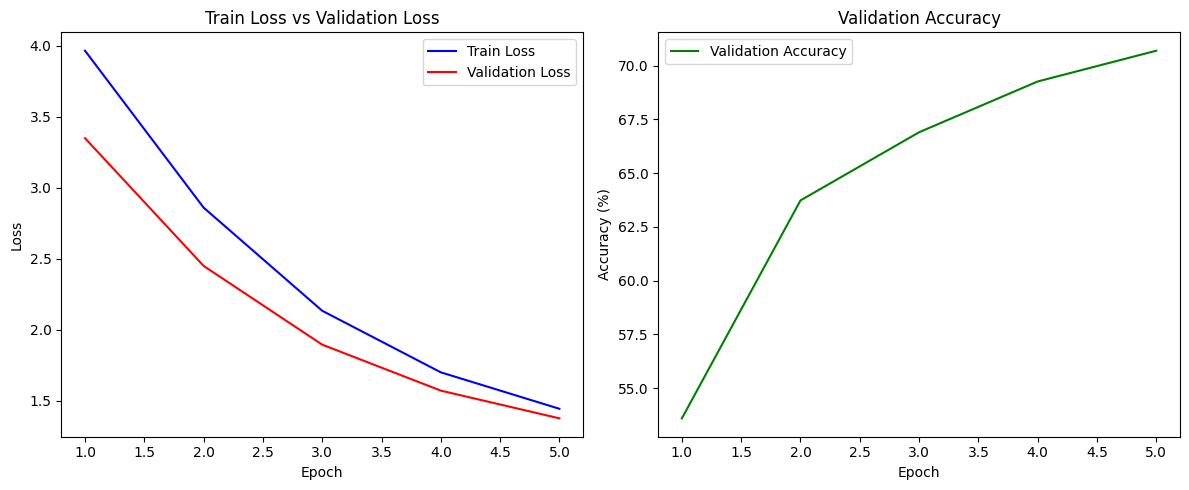

Total Training Time: 996.55 seconds


In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from transformers import SwinForImageClassification, AutoImageProcessor
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from torchinfo import summary
from ptflops import get_model_complexity_info


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5
batch_size = 32
learning_rate = 2e-5
image_size = 224  

# Data preparation
processor = AutoImageProcessor.from_pretrained("microsoft/swin-small-patch4-window7-224")

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                             download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-small-patch4-window7-224",
    num_labels=100,  
    ignore_mismatched_sizes=True  
).to(device)

# Freeze backbone parameters and only train the classification head
for param in model.swin.parameters():
    param.requires_grad = False

# Only the classifier head will be trained
for param in model.classifier.parameters():
    param.requires_grad = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)


train_losses = []
val_losses = []
val_accuracies = []
train_times = []

# Training function
def train():
    model.train()
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]')

        for i, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i+1) % 100 == 0:
                progress_bar.set_postfix({'loss': loss.item()})
        
     
        avg_train_loss = running_loss / total_step
        train_losses.append(avg_train_loss)
        
    
        val_loss, val_accuracy = validate()
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
       
        epoch_time = time.time() - start_time
        train_times.append(epoch_time)
    
        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}% | Time: {epoch_time:.2f}s')

# Testing function (validation)
def validate():
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(test_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(test_loader)
        accuracy = 100 * correct / total
        return avg_val_loss, accuracy

# Run training and testing
if __name__ == '__main__':
    print("Downloading pretrained weights and starting fine-tuning...")
    info = summary(model, input_size=(batch_size, 3, image_size, image_size), device=device, verbose=0)
    total_params = info.total_params
    trainable_params = info.trainable_params

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    
    macs, params = get_model_complexity_info(model, (3, image_size, image_size), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f"\n Model Complexity:\nMACs: {macs} | FLOPs: 2*{macs} | Params: {params}")
    
    train()
    
    print("\nEvaluating fine-tuned model...")
    val_loss, val_accuracy = validate()
    print(f'Final Test Accuracy: {val_accuracy:.2f}%')

    
    plt.figure(figsize=(12, 5))

   
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
    plt.title('Train Loss vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

   
    total_train_time = sum(train_times)
    print(f"Total Training Time: {total_train_time:.2f} seconds")
